In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# === 1) Paths: update to your local/Colab paths ===
path_owid_co2 = "/content/drive/MyDrive/GreenCalc/owid-co2-data___.csv"          # OWID CO2 dataset
path_owid_energy = "/content/drive/MyDrive/GreenCalc/owid-energy-data.csv"     # OWID Energy dataset (from owid/energy-data)
path_wb = "/content/drive/MyDrive/GreenCalc/wb_india_indicators.csv"           # (optional for now) WB export with EG.FEC.RNEW.ZS etc.

# === 2) Load what you have (skip missing ones; we just verify) ===
def safe_read(p):
    try:
        return pd.read_csv(p)
    except Exception as e:
        print(f"Could not read {p}: {e}")
        return None

co2 = safe_read(path_owid_co2)
energy = safe_read(path_owid_energy)
wb = safe_read(path_wb)

def cols(df):
    return [] if df is None else list(df.columns)

print("\n=== Files present & column counts ===")
print("OWID CO2:", 0 if co2 is None else co2.shape, "cols=", len(cols(co2)))
print("OWID Energy:", 0 if energy is None else energy.shape, "cols=", len(cols(energy)))
print("World Bank:", 0 if wb is None else wb.shape, "cols=", len(cols(wb)))

# === 3) Check India coverage + key columns ===
def check_columns(df, label, country_col="country", country_name="India", needed=None):
    if df is None:
        print(f"\n[{label}] file missing — skip.")
        return
    sub = df[df[country_col]==country_name] if country_col in df.columns else df
    print(f"\n[{label}] India rows:", 0 if sub is None else sub.shape)
    if needed:
        missing = [c for c in needed if c not in df.columns]
        if missing:
            print(f"[{label}] MISSING columns: {missing}")
        else:
            print(f"[{label}] All needed columns found ✅")

# CO2 dataset: core variables we rely on
need_co2 = ["year","country","gdp","population","energy_per_gdp","co2_per_capita",
            "coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2","land_use_change_co2"]
check_columns(co2, "OWID CO2", needed=need_co2)

# Energy/electricity mix: names vary—OWID energy uses explicit share columns
# Common fields include: share_electricity_coal, share_electricity_gas, share_electricity_renewables (naming differs by export)
# We'll check a few likely names; if they differ, we’ll map them next step.
likely_energy_cols = [
    "share_electricity_coal","share_electricity_gas","share_electricity_renewables",
    "electricity_from_coal","electricity_from_gas","electricity_from_renewables"
]
present_energy_cols = [c for c in likely_energy_cols if energy is not None and c in energy.columns]
print("\n[OWID Energy] Found potential electricity-mix columns:", present_energy_cols if present_energy_cols else "None detected yet")
check_columns(energy, "OWID Energy", needed=["year","country"])

# World Bank (optional now): verify renewables %
wb_needed = ["year"]  # EG.FEC.RNEW.ZS after you export it
check_columns(wb, "World Bank (optional)", needed=wb_needed)


Could not read /content/drive/MyDrive/GreenCalc/wb_india_indicators.csv: Error tokenizing data. C error: Expected 3 fields in line 5, saw 70


=== Files present & column counts ===
OWID CO2: (50191, 79) cols= 79
OWID Energy: (23195, 130) cols= 130
World Bank: 0 cols= 0

[OWID CO2] India rows: (174, 79)
[OWID CO2] All needed columns found ✅

[OWID Energy] Found potential electricity-mix columns: None detected yet

[OWID Energy] India rows: (125, 130)
[OWID Energy] All needed columns found ✅

[World Bank (optional)] file missing — skip.


In [ ]:
import pandas as pd
import numpy as np

# === set your path to the OWID Energy csv ===
path_owid_energy = "/content/drive/MyDrive/GreenCalc/owid-energy-data.csv"  # <- change if needed

energy = pd.read_csv(path_owid_energy)
ind_energy = energy[energy["country"]=="India"].copy().reset_index(drop=True)

# 1) Inspect likely share/electricity columns
cand_cols = [c for c in ind_energy.columns if ("electricity" in c.lower() or "share" in c.lower())]
print("🔎 Columns containing 'electricity' or 'share' (first 60):")
print(cand_cols[:60])

# 2) Try to use direct share columns if they exist (names vary by OWID version)
possible_direct = {
    "coal":  [ "share_electricity_coal", "electricity_share_coal", "share_of_electricity_from_coal" ],
    "gas":   [ "share_electricity_gas", "electricity_share_gas", "share_of_electricity_from_gas" ],
    "renew": [ "share_electricity_renewables", "electricity_share_renewables", "share_of_electricity_from_renewables" ]
}

direct_map = {}
for key, opts in possible_direct.items():
    found = [c for c in opts if c in ind_energy.columns]
    direct_map[key] = found[0] if found else None

print("\n✅ Direct share columns detected (if any):", direct_map)

# 3) Build a small frame with year + final shares
out = ind_energy[["year"]].copy()

def use_or_derive(source_key, from_cols_prefix):
    """
    Return a pandas Series with the share for the given source (coal/gas/renew),
    either from a direct share column or by deriving from 'electricity_from_*'.
    """
    direct_col = direct_map[source_key]
    if direct_col is not None:
        # Already a percentage or fraction; keep as-is
        return ind_energy[direct_col]
    else:
        # derive: share = electricity_from_X / total_electricity_from_all
        # find all 'electricity_from_*' columns
        from_cols = [c for c in ind_energy.columns if c.startswith("electricity_from_")]
        if not from_cols:
            return pd.Series(np.nan, index=ind_energy.index)
        # total electricity (sum across all 'electricity_from_*')
        total = ind_energy[from_cols].sum(axis=1, skipna=True)
        # pick the relevant source column names we might have
        if source_key == "coal":
            src_candidates = [c for c in from_cols if "coal" in c]
        elif source_key == "gas":
            src_candidates = [c for c in from_cols if "gas" in c]
        else:  # renewables (sum wind/solar/hydro/bio/geo etc.)
            # common renewable components in OWID energy
            renew_keywords = ["renew", "wind", "solar", "hydro", "bio", "geothermal", "other_renewables"]
            src_candidates = [c for c in from_cols if any(k in c for k in renew_keywords)]
        if not src_candidates:
            return pd.Series(np.nan, index=ind_energy.index)
        src_sum = ind_energy[src_candidates].sum(axis=1, skipna=True)
        # avoid divide by zero
        share = np.where(total>0, src_sum/total, np.nan)
        return pd.Series(share, index=ind_energy.index)

out["share_coal_elec"] = use_or_derive("coal", "electricity_from_")
out["share_gas_elec"] = use_or_derive("gas", "electricity_from_")
out["share_renewables_elec"] = use_or_derive("renew", "electricity_from_")

# 4) Clean/impute a bit (optional): clamp between 0 and 1
for c in ["share_coal_elec","share_gas_elec","share_renewables_elec"]:
    out[c] = pd.to_numeric(out[c], errors="coerce")
    out[c] = out[c].clip(lower=0, upper=1)

print("\n📋 Electricity mix preview (India):")
print(out.head(12))

# 5) Save a temporary CSV for later merging
save_path = "/content/drive/MyDrive/GreenCalc/india_energy_shares.csv"
out.to_csv(save_path, index=False)
print(f"\nSaved electricity mix shares to: {save_path}")


🔎 Columns containing 'electricity' or 'share' (first 60):
['biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'coal_electricity', 'coal_share_elec', 'coal_share_energy', 'electricity_demand', 'electricity_demand_per_capita', 'electricity_generation', 'electricity_share_energy', 'fossil_electricity', 'fossil_share_elec', 'fossil_share_energy', 'gas_electricity', 'gas_share_elec', 'gas_share_energy', 'hydro_electricity', 'hydro_share_elec', 'hydro_share_energy', 'low_carbon_electricity', 'low_carbon_share_elec', 'low_carbon_share_energy', 'net_elec_imports_share_demand', 'nuclear_electricity', 'nuclear_share_elec', 'nuclear_share_energy', 'oil_electricity', 'oil_share_elec', 'oil_share_energy', 'other_renewable_electricity', 'other_renewable_exc_biofuel_electricity', 'other_renewables_share_elec', 'other_renewables_share_elec_exc_biofuel', 'other_renewables_share_energy', 'per_capita_electricity', 'renewables_electricity', 'renewables_share_elec', 'renewables_share_ener

In [ ]:
import pandas as pd
import numpy as np

path_owid_energy = "/content/drive/MyDrive/GreenCalc/owid-energy-data.csv"  # ← adjust if needed
save_path = "/content/drive/MyDrive/GreenCalc/india_energy_shares.csv"

def _normalize_share(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    # If values look like percentages (>1), convert to 0–1
    if s.dropna().max() is not None and s.dropna().max() > 1:
        s = s / 100.0
    return s.clip(lower=0, upper=1)

energy = pd.read_csv(path_owid_energy)
ind = energy[energy["country"]=="India"].copy().reset_index(drop=True)

out = ind[["year"]].copy()

# Prefer direct share columns if present
has_coal_share = "coal_share_elec" in ind.columns
has_gas_share = "gas_share_elec" in ind.columns
has_ren_share = "renewables_share_elec" in ind.columns

# Start with NaNs
out["share_coal_elec"] = np.nan
out["share_gas_elec"] = np.nan
out["share_renewables_elec"] = np.nan

# Use direct shares when available
if has_coal_share:
    out["share_coal_elec"] = _normalize_share(ind["coal_share_elec"])
if has_gas_share:
    out["share_gas_elec"] = _normalize_share(ind["gas_share_elec"])
if has_ren_share:
    out["share_renewables_elec"] = _normalize_share(ind["renewables_share_elec"])

# Fallback: derive from MWh/GWh values
need_coal = out["share_coal_elec"].isna()
need_gas = out["share_gas_elec"].isna()
need_ren = out["share_renewables_elec"].isna()

if "electricity_generation" in ind.columns:
    total = pd.to_numeric(ind["electricity_generation"], errors="coerce")

    if need_coal.any() and "coal_electricity" in ind.columns:
        coal_e = pd.to_numeric(ind["coal_electricity"], errors="coerce")
        out.loc[need_coal, "share_coal_elec"] = (coal_e / total).where(total > 0)

    if need_gas.any() and "gas_electricity" in ind.columns:
        gas_e = pd.to_numeric(ind["gas_electricity"], errors="coerce")
        out.loc[need_gas, "share_gas_elec"] = (gas_e / total).where(total > 0)

    if need_ren.any():
        # Sum renewables if single column missing
        if "renewables_electricity" in ind.columns:
            ren_e = pd.to_numeric(ind["renewables_electricity"], errors="coerce")
        else:
            # Compose from components if needed
            comps = [c for c in ind.columns if c.endswith("_electricity") and any(k in c for k in ["wind","solar","hydro","biofuel","geothermal","other_renewable"])]
            ren_e = ind[comps].apply(pd.to_numeric, errors="coerce").sum(axis=1) if comps else np.nan
        out.loc[need_ren, "share_renewables_elec"] = (ren_e / total).where(total > 0)

# Final clean
for c in ["share_coal_elec","share_gas_elec","share_renewables_elec"]:
    out[c] = _normalize_share(out[c])

# Keep the modeling window
out = out[(out["year"]>=1960) & (out["year"]<=2023)].reset_index(drop=True)

print("Preview:")
print(out.head(10))
print("\nCoverage (non-null counts):")
print(out[["share_coal_elec","share_gas_elec","share_renewables_elec"]].notna().sum())

out.to_csv(save_path, index=False)
print(f"\nSaved electricity mix shares to: {save_path}")


Preview:
   year  share_coal_elec  share_gas_elec  share_renewables_elec
0  1960              NaN             NaN                    NaN
1  1961              NaN             NaN                    NaN
2  1962              NaN             NaN                    NaN
3  1963              NaN             NaN                    NaN
4  1964              NaN             NaN                    NaN
5  1965              NaN             NaN                    NaN
6  1966              NaN             NaN                    NaN
7  1967              NaN             NaN                    NaN
8  1968              NaN             NaN                    NaN
9  1969              NaN             NaN                    NaN

Coverage (non-null counts):
share_coal_elec          39
share_gas_elec           39
share_renewables_elec    39
dtype: int64

Saved electricity mix shares to: /content/drive/MyDrive/GreenCalc/india_energy_shares.csv


In [ ]:
import pandas as pd
import numpy as np

# --- Paths (adjust only if needed) ---
path_owid_co2      = "/content/drive/MyDrive/GreenCalc/owid-co2-data.csv"
path_energy_shares = "/content/drive/MyDrive/GreenCalc/india_energy_shares.csv"
save_master        = "/content/drive/MyDrive/GreenCalc/india_clean_master.csv"

# --- 1) Load OWID CO2 and filter India ---
co2 = pd.read_csv(path_owid_co2)
ind = co2[co2["country"]=="India"].copy()

# Required core columns (keep what exists)
core_cols = [
    "year", "gdp", "population", "energy_per_gdp", "co2_per_capita",
    # optional useful columns if present
    "coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2","land_use_change_co2",
    "energy_per_capita","co2_per_unit_energy","share_global_co2","share_global_cumulative_co2",
    "temperature_change_from_co2"
]
present_core = [c for c in core_cols if c in ind.columns]
ind = ind[present_core].copy()

# --- 2) Load electricity mix shares ---
mix = pd.read_csv(path_energy_shares)  # expected cols: year, share_coal_elec, share_gas_elec, share_renewables_elec

# --- 3) Merge on year (left join: keep all India years from CO2 data) ---
df = ind.merge(mix, on="year", how="left")

# --- 4) Restrict modeling window (1960–2023), sort ---
df = df[(df["year"]>=1960) & (df["year"]<=2023)].sort_values("year").reset_index(drop=True)

# --- 5) Numeric conversion + interpolation ---
num_cols = [c for c in df.columns if c != "year"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Time-wise interpolation on a yearly index
df = df.set_index("year")
df[num_cols] = df[num_cols].interpolate(method="linear", limit_direction="both")
df[num_cols] = df[num_cols].fillna(method="ffill").fillna(method="bfill")
df = df.reset_index()

# --- 6) Optional: ensure electricity shares are within [0,1] ---
for c in ["share_coal_elec","share_gas_elec","share_renewables_elec"]:
    if c in df.columns:
        df[c] = df[c].clip(lower=0, upper=1)

# --- 7) Add a simple lag feature for target (useful later for models) ---
if "co2_per_capita" in df.columns:
    df["co2_per_capita_lag1"] = df["co2_per_capita"].shift(1)
    # Drop first row created by lag
    df = df.dropna(subset=["co2_per_capita_lag1"]).reset_index(drop=True)

# --- 8) Save master dataset ---
df.to_csv(save_master, index=False)

# --- 9) Quick summary printouts ---
print("✅ Master dataset saved to:", save_master)
print("\n=== Shape ===")
print(df.shape)

print("\n=== Columns ===")
print(list(df.columns))

print("\n=== Non-null counts (key fields) ===")
keys = ["gdp","population","energy_per_gdp","co2_per_capita",
        "share_coal_elec","share_gas_elec","share_renewables_elec","co2_per_capita_lag1"]
for k in keys:
    if k in df.columns:
        print(f"{k:>24}: {df[k].notna().sum()}")

print("\n=== Preview (last 8 rows) ===")
print(df.tail(8))


/tmp/ipython-input-1312213230.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_cols] = df[num_cols].fillna(method="ffill").fillna(method="bfill")


✅ Master dataset saved to: /content/drive/MyDrive/GreenCalc/india_clean_master.csv

=== Shape ===
(63, 20)

=== Columns ===
['year', 'gdp', 'population', 'energy_per_gdp', 'co2_per_capita', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2', 'flaring_co2', 'land_use_change_co2', 'energy_per_capita', 'co2_per_unit_energy', 'share_global_co2', 'share_global_cumulative_co2', 'temperature_change_from_co2', 'share_coal_elec', 'share_gas_elec', 'share_renewables_elec', 'co2_per_capita_lag1']

=== Non-null counts (key fields) ===
                     gdp: 63
              population: 63
          energy_per_gdp: 63
          co2_per_capita: 63
         share_coal_elec: 63
          share_gas_elec: 63
   share_renewables_elec: 63
     co2_per_capita_lag1: 63

=== Preview (last 8 rows) ===
    year           gdp    population  energy_per_gdp  co2_per_capita  \
55  2016  8.057466e+12  1.343944e+09           1.028           1.752   
56  2017  8.550029e+12  1.359657e+09           1.006           1.785


=== 📊 Model Evaluation (XGBoost) ===
R² Score : -1.5424
MAE      : 0.1317
RMSE     : 0.1560


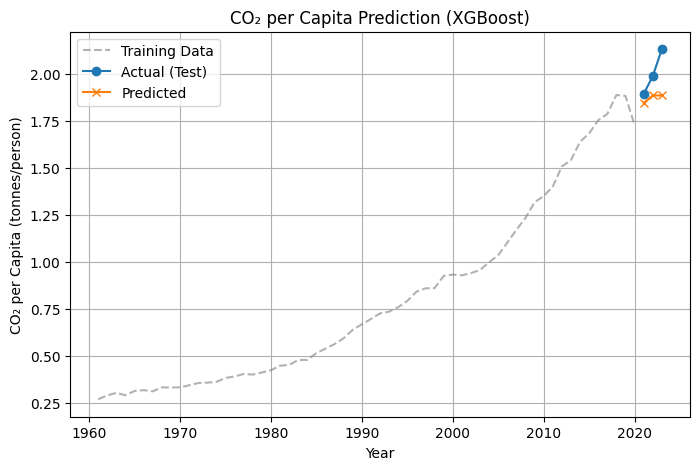


✅ Model, scaler, and predictions saved successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

# === 1. Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/GreenCalc/india_clean_master.csv")

# === 2. Define features and target ===
target = "co2_per_capita"
features = [c for c in df.columns if c not in ["year", target]]

X = df[features]
y = df[target]

# === 3. Train-test split (chronological, last 3 years as test) ===
split_idx = df[df["year"] <= 2020].index.max() + 1
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
years_train = df.loc[:split_idx-1, "year"]
years_test = df.loc[split_idx:, "year"]

# === 4. Scale numeric features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Train XGBoost model ===
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)
model.fit(X_train_scaled, y_train)

# === 6. Evaluate ===
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== 📊 Model Evaluation (XGBoost) ===")
print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"RMSE     : {rmse:.4f}")

# === 7. Plot actual vs predicted ===
plt.figure(figsize=(8,5))
plt.plot(years_train, y_train, label="Training Data", color="gray", linestyle="--", alpha=0.6)
plt.plot(years_test, y_test, label="Actual (Test)", marker="o")
plt.plot(years_test, y_pred, label="Predicted", marker="x")
plt.title("CO₂ per Capita Prediction (XGBoost)")
plt.xlabel("Year")
plt.ylabel("CO₂ per Capita (tonnes/person)")
plt.legend()
plt.grid(True)
plt.show()

# === 8. Save model and predictions for later ===
joblib.dump(model, "/content/drive/MyDrive/GreenCalc/xgb_model.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/GreenCalc/xgb_scaler.pkl")

pred_df = pd.DataFrame({
    "year": years_test,
    "actual": y_test.values,
    "predicted": y_pred
})
pred_df.to_csv("/content/drive/MyDrive/GreenCalc/xgb_predictions.csv", index=False)

print("\n✅ Model, scaler, and predictions saved successfully.")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✅ Best Parameters Found:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1200, 'subsample': 0.8}

=== 📊 Tuned Model Evaluation (XGBoost) ===
R² Score : -1.5327
MAE      : 0.1319
RMSE     : 0.1557


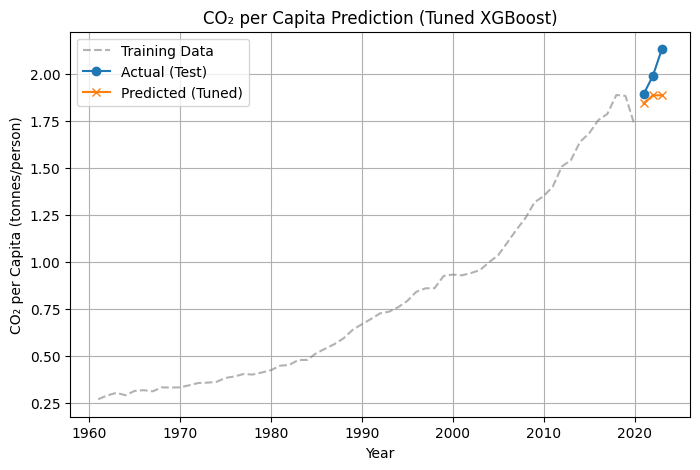

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# === Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/GreenCalc/india_clean_master.csv")

target = "co2_per_capita"
features = [c for c in df.columns if c not in ["year", target]]

X = df[features]
y = df[target]
years = df["year"]

# === Train/test split (keep 2021–2023 as test) ===
split_idx = df[df["year"] <= 2020].index.max() + 1
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
years_train, years_test = years.iloc[:split_idx], years.iloc[split_idx:]

# === Scaling ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === TimeSeriesSplit for XGBoost tuning ===
tscv = TimeSeriesSplit(n_splits=5)

# === Grid search space ===
param_grid = {
    "n_estimators": [400, 800, 1200],
    "learning_rate": [0.03, 0.05, 0.08],
    "max_depth": [4, 5, 6],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

xgb_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)

# === Retrain model using best parameters ===
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# === Evaluate ===
y_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== 📊 Tuned Model Evaluation (XGBoost) ===")
print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"RMSE     : {rmse:.4f}")

# === Plot ===
plt.figure(figsize=(8,5))
plt.plot(years_train, y_train, label="Training Data", color="gray", linestyle="--", alpha=0.6)
plt.plot(years_test, y_test, label="Actual (Test)", marker="o")
plt.plot(years_test, y_pred, label="Predicted (Tuned)", marker="x")
plt.title("CO₂ per Capita Prediction (Tuned XGBoost)")
plt.xlabel("Year")
plt.ylabel("CO₂ per Capita (tonnes/person)")
plt.legend()
plt.grid(True)
plt.show()


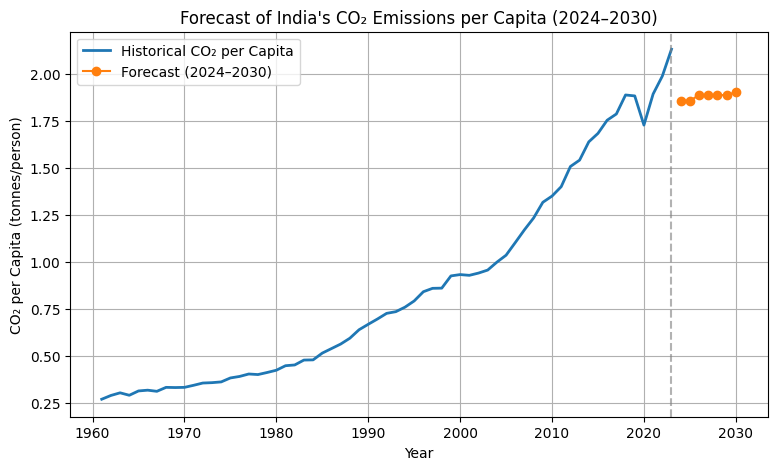

✅ Forecast saved to: /content/drive/MyDrive/GreenCalc/co2_forecast_2024_2030.csv

=== 🌍 Decoupling Summary ===
2012 → 2023 GDP growth ≈ 73.1%
2012 → 2023 CO₂ per capita growth ≈ 41.4%
2024 → 2030 Forecasted CO₂ per capita growth ≈ -10.7%
✅ Relative decoupling evident (GDP grew faster than per-capita emissions).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# === 1) Load master dataset ===
df = pd.read_csv("/content/drive/MyDrive/GreenCalc/india_clean_master.csv")

target = "co2_per_capita"
features = [c for c in df.columns if c not in ["year", target]]
years = df["year"].values

# === 2) Scale features and fit tuned model on ALL data till 2023 ===
X_hist = df[features].copy()
y_hist = df[target].copy()

scaler = StandardScaler()
X_hist_scaled = scaler.fit_transform(X_hist)

best_params = {
    "colsample_bytree": 1.0,
    "learning_rate": 0.05,
    "max_depth": 6,
    "n_estimators": 1200,
    "subsample": 0.8,
    "random_state": 42,
}
model = XGBRegressor(**best_params)
model.fit(X_hist_scaled, y_hist)

# === 3) Build future driver dataframe (2024–2030) ===
future_years = np.arange(2024, 2031)
future = pd.DataFrame({"year": future_years})

# Smooth trend extension for key drivers
for col in ["gdp", "population", "energy_per_gdp",
            "share_coal_elec", "share_gas_elec", "share_renewables_elec"]:
    if col in df.columns:
        coeffs = np.polyfit(df["year"], df[col], 1)  # linear trend
        future[col] = np.polyval(coeffs, future_years)

# For any remaining feature not in future (static carry-forward)
for c in features:
    if c not in future.columns:
        future[c] = df[c].iloc[-1]

# Clamp shares to [0,1] just in case
for c in ["share_coal_elec", "share_gas_elec", "share_renewables_elec"]:
    if c in future.columns:
        future[c] = future[c].clip(0, 1)

# === 4) Iterative (rolling) forecast to respect lag feature ===
history_last_y = df[target].iloc[-1]
preds = []

# We'll create a working copy of future rows and fill lag each iteration
for i in range(len(future)):
    row = future.iloc[i].copy()

    # set lag = last known/predicted y
    row["co2_per_capita_lag1"] = history_last_y

    # ensure all required features present in correct order
    row_X = row[features].to_frame().T  # 1xN
    row_X_scaled = scaler.transform(row_X)

    y_hat = model.predict(row_X_scaled)[0]
    preds.append(y_hat)

    # update lag for next iteration
    history_last_y = y_hat

future["predicted_co2_per_capita"] = preds

# === 5) Combine historical + forecast and save ===
combined = pd.concat([
    df[["year", target]].rename(columns={target: "actual_co2_per_capita"}),
    future[["year", "predicted_co2_per_capita"]]
], ignore_index=True)

combined.to_csv("/content/drive/MyDrive/GreenCalc/co2_forecast_2024_2030.csv", index=False)

# === 6) Plot ===
plt.figure(figsize=(9,5))
plt.plot(df["year"], df[target], label="Historical CO₂ per Capita", lw=2)
plt.plot(future["year"], future["predicted_co2_per_capita"],
         label="Forecast (2024–2030)", marker="o")
plt.axvline(2023, color="gray", linestyle="--", alpha=0.6)
plt.title("Forecast of India's CO₂ Emissions per Capita (2024–2030)")
plt.xlabel("Year")
plt.ylabel("CO₂ per Capita (tonnes/person)")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Forecast saved to: /content/drive/MyDrive/GreenCalc/co2_forecast_2024_2030.csv")

# === 7) Quick decoupling-style summary ===
gdp_2012 = df.loc[df["year"]==2012, "gdp"].values[0]
gdp_2023 = df.loc[df["year"]==2023, "gdp"].values[0]
co2_2012 = df.loc[df["year"]==2012, target].values[0]
co2_2023 = df.loc[df["year"]==2023, target].values[0]

gdp_growth_2012_2023 = (gdp_2023 - gdp_2012) / gdp_2012 * 100
co2_growth_2012_2023 = (co2_2023 - co2_2012) / co2_2012 * 100
co2_growth_2024_2030 = (future["predicted_co2_per_capita"].iloc[-1] - co2_2023) / co2_2023 * 100

print("\n=== 🌍 Decoupling Summary ===")
print(f"2012 → 2023 GDP growth ≈ {gdp_growth_2012_2023:.1f}%")
print(f"2012 → 2023 CO₂ per capita growth ≈ {co2_growth_2012_2023:.1f}%")
print(f"2024 → 2030 Forecasted CO₂ per capita growth ≈ {co2_growth_2024_2030:.1f}%")
if gdp_growth_2012_2023 > co2_growth_2012_2023:
    print("✅ Relative decoupling evident (GDP grew faster than per-capita emissions).")
else:
    print("⚠️ Limited decoupling; emissions kept pace with or exceeded GDP growth.")


TreeExplainer failed, falling back to PermutationExplainer.
Reason: could not convert string to float: '[8.61254E-1]'


PermutationExplainer explainer: 64it [00:32,  1.46it/s]


✅ SHAP values saved (permutation) -> /content/drive/MyDrive/GreenCalc/shap_values_india.csv

=== 📌 Mean |SHAP| (global impact ranking) ===
                Feature  MeanAbsSHAP
0                   gdp     0.430821
4               oil_co2     0.008319
3              coal_co2     0.004703
1            population     0.004557
10  co2_per_unit_energy     0.001783
9     energy_per_capita     0.001565
2        energy_per_gdp     0.001014
11     share_global_co2     0.000907
8   land_use_change_co2     0.000875
15       share_gas_elec     0.000585


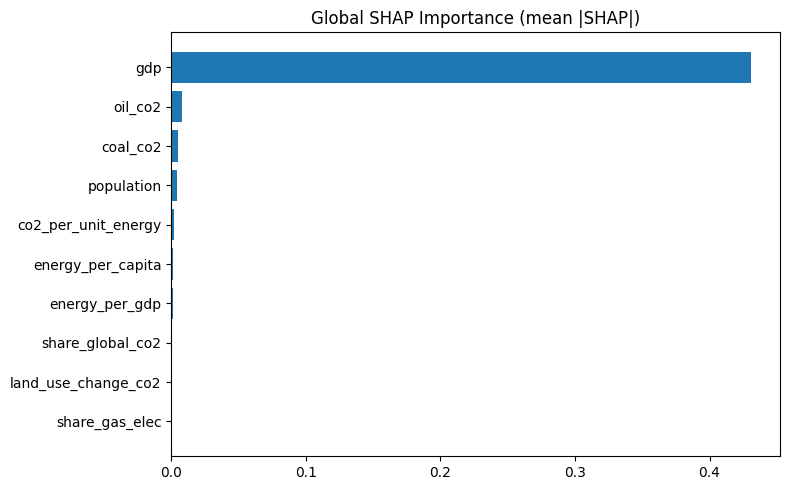

/tmp/ipython-input-349556305.py:63: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_expl, show=False)


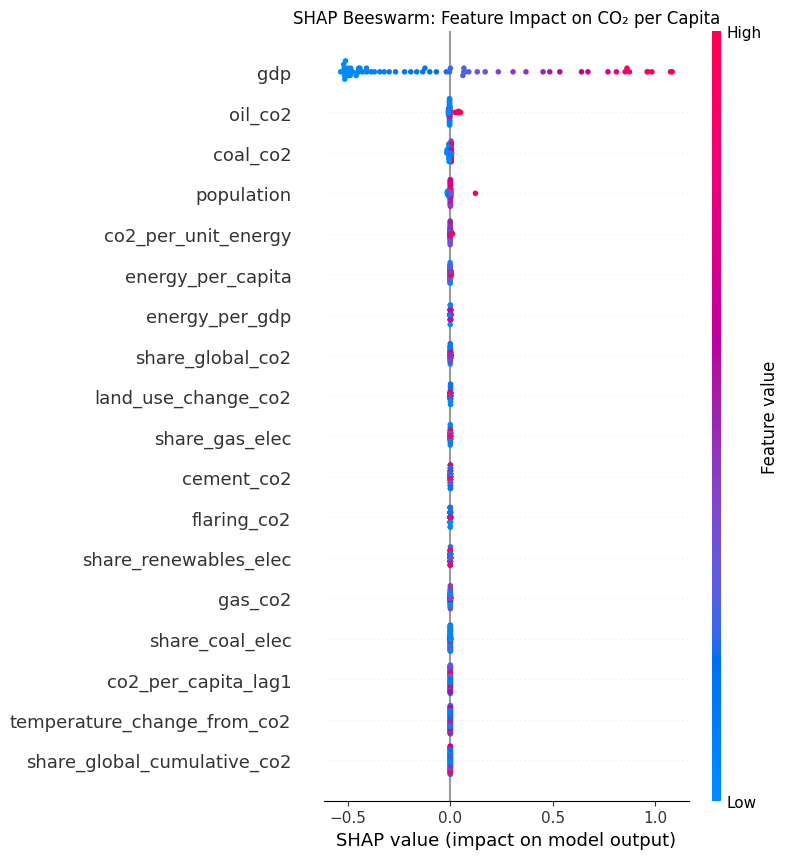

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
import os

# === Load data ===
df = pd.read_csv("/content/drive/MyDrive/GreenCalc/india_clean_master.csv")
target = "co2_per_capita"
features = [c for c in df.columns if c not in ["year", target]]
X = df[features].copy()
y = df[target].copy()

# === Train tuned XGB on UN-SCALED features ===
best_params = {
    "colsample_bytree": 1.0,
    "learning_rate": 0.05,
    "max_depth": 6,
    "n_estimators": 1200,
    "subsample": 0.8,
    "random_state": 42,
}
model = XGBRegressor(**best_params)
model.fit(X, y)

# === Try TreeExplainer -> if it fails, use PermutationExplainer ===
save_dir = "/content/drive/MyDrive/GreenCalc"
os.makedirs(save_dir, exist_ok=True)

try:
    explainer = shap.TreeExplainer(model)
    shap_expl = explainer(X)                 # <-- returns a shap.Explanation
    mode = "tree"
except Exception as e:
    print("TreeExplainer failed, falling back to PermutationExplainer.\nReason:", e)
    explainer = shap.Explainer(model.predict, X, algorithm="permutation")
    shap_expl = explainer(X)                 # <-- returns a shap.Explanation
    mode = "permutation"

# === Save SHAP values ===
shap_df = pd.DataFrame(shap_expl.values, columns=features)
shap_df["year"] = df["year"]
shap_df.to_csv(f"{save_dir}/shap_values_india.csv", index=False)
print(f"✅ SHAP values saved ({mode}) -> {save_dir}/shap_values_india.csv")

# === Global importance (mean |SHAP|) ===
mean_abs = np.abs(shap_expl.values).mean(axis=0)
mean_abs_df = pd.DataFrame({"Feature": features, "MeanAbsSHAP": mean_abs}).sort_values("MeanAbsSHAP", ascending=False)
print("\n=== 📌 Mean |SHAP| (global impact ranking) ===")
print(mean_abs_df.head(10))

# === Plots ===
# Global SHAP importance bar
plt.figure(figsize=(8,5))
plt.barh(mean_abs_df["Feature"].head(10)[::-1], mean_abs_df["MeanAbsSHAP"].head(10)[::-1])
plt.title("Global SHAP Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

# Beeswarm (direction + magnitude)
# Use the Explanation directly so SHAP has base_values & data
shap.summary_plot(shap_expl, show=False)
plt.title("SHAP Beeswarm: Feature Impact on CO₂ per Capita")
plt.tight_layout()
plt.show()


In [ ]:
# make a clean working folder
!mkdir -p /content/greencalc

# copy your files from Drive (adjust paths only if yours differ)
!cp "/content/drive/MyDrive/GreenCalc/india_clean_master.csv" /content/greencalc/
!cp "/content/drive/MyDrive/GreenCalc/co2_forecast_2024_2030.csv" /content/greencalc/ || true
!cp "/content/drive/MyDrive/GreenCalc/shap_values_india.csv" /content/greencalc/ || true

!ls -lah /content/greencalc

total 48K
drwxr-xr-x 2 root root 4.0K Nov  8 06:09 .
drwxr-xr-x 1 root root 4.0K Nov  8 06:09 ..
-rw------- 1 root root  914 Nov  8 06:09 co2_forecast_2024_2030.csv
-rw------- 1 root root 9.8K Nov  8 06:09 india_clean_master.csv
-rw------- 1 root root  22K Nov  8 06:09 shap_values_india.csv


In [ ]:
%%writefile /content/greencalc/app.py
import pandas as pd
import numpy as np
import streamlit as st
import plotly.express as px
from pathlib import Path

st.set_page_config(page_title="GreenCalc AI", page_icon="🌿", layout="wide")

# Paths (we’ll use the copies inside /content/greencalc)
PATH_MASTER = Path("/content/greencalc/india_clean_master.csv")
PATH_FORECAST = Path("/content/greencalc/co2_forecast_2024_2030.csv")
PATH_SHAP = Path("/content/greencalc/shap_values_india.csv")

@st.cache_data
def load_master():
    return pd.read_csv(PATH_MASTER)

@st.cache_data
def load_forecast():
    return pd.read_csv(PATH_FORECAST) if PATH_FORECAST.exists() else None

@st.cache_data
def load_shap():
    if not PATH_SHAP.exists():
        return None, None
    shap_df = pd.read_csv(PATH_SHAP)
    feat_cols = [c for c in shap_df.columns if c != "year"]
    mean_abs = shap_df[feat_cols].abs().mean().sort_values(ascending=False)
    rank_df = pd.DataFrame({"Feature": mean_abs.index, "MeanAbsSHAP": mean_abs.values})
    return shap_df, rank_df

st.title("🌿 GreenCalc AI — India CO₂ Analytics Dashboard")

tab_overview, tab_forecast, tab_explain = st.tabs(["📊 Overview", "🔮 Forecast", "🧠 Explainability"])

with tab_overview:
    st.subheader("Dataset Preview & Historical Trend")
    df = load_master()
    st.dataframe(df.tail(10), use_container_width=True)

    fig = px.line(df, x="year", y="co2_per_capita",
                  title="Historical CO₂ per Capita (tonnes/person)", markers=True)
    st.plotly_chart(fig, use_container_width=True)

    c1, c2, c3 = st.columns(3)
    c1.metric("Latest CO₂ per Capita", f"{df['co2_per_capita'].iloc[-1]:.3f}")
    c2.metric("Latest GDP (₹)", f"{df['gdp'].iloc[-1]:.3e}")
    c3.metric("Population", f"{df['population'].iloc[-1]:.0f}")

with tab_forecast:
    st.subheader("CO₂ per Capita Forecast (2024–2030)")
    fcast = load_forecast()
    if fcast is None:
        st.info("No forecast file found. Generate it in the notebook, then refresh.")
    else:
        hist = df[["year","co2_per_capita"]].rename(columns={"co2_per_capita":"value"})
        pred = fcast.rename(columns={"predicted_co2_per_capita":"value"})
        if "value" not in pred.columns and "predicted_co2_per_capita" in fcast.columns:
            pred = fcast[["year","predicted_co2_per_capita"]].rename(columns={"predicted_co2_per_capita":"value"})
        hist["type"] = "Actual"
        pred["type"] = "Forecast"
        comb = pd.concat([hist, pred], ignore_index=True)

        fig2 = px.line(comb, x="year", y="value", color="type",
                       title="Actual vs Forecast CO₂ per Capita", markers=True)
        st.plotly_chart(fig2, use_container_width=True)
        st.dataframe(pred[pred["year"]>=2024], use_container_width=True)

with tab_explain:
    st.subheader("Global Feature Importance (Mean |SHAP|)")
    shap_df, rank_df = load_shap()
    if rank_df is None:
        st.info("Run the SHAP step to generate `shap_values_india.csv`, then refresh.")
    else:
        topn = st.slider("Top N features", 5, min(20, len(rank_df)), 10)
        fig3 = px.bar(rank_df.head(topn).sort_values("MeanAbsSHAP"),
                      x="MeanAbsSHAP", y="Feature", orientation="h",
                      title="Mean |SHAP| Importance")
        st.plotly_chart(fig3, use_container_width=True)

st.caption("© 2025 GreenCalc AI · Streamlit Dashboard")


Writing /content/greencalc/app.py


In [ ]:
pip install -q streamlit plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.1 MB/s eta 0:00:00


In [ ]:
!pip install -q pyngrok

from pyngrok import ngrok
import subprocess, time

# kill old tunnels if any
ngrok.kill()

# start streamlit
proc = subprocess.Popen(["streamlit", "run", "/content/greencalc/app.py", "--server.port=8501", "--server.address=0.0.0.0"])

# open public URL
public_url = ngrok.connect(8501).public_url
print("🚀 Your app is live at:", public_url)


🚀 Your app is live at: https://deedee-unpealed-louann.ngrok-free.dev


To use `pyngrok`, you need to authenticate with your ngrok authtoken.

1.  Go to your ngrok dashboard (https://dashboard.ngrok.com/get-started/your-authtoken) to find your authtoken.
2.  In Colab, click on the "🔑" icon in the left sidebar to open the Secrets Manager.
3.  Click "New secret".
4.  For the "Name", enter `NGROK_AUTH_TOKEN`.
5.  For the "Value", paste your authtoken.
6.  Ensure "Notebook access" is checked.
7.  Run the cell below to apply the authtoken.

In [ ]:
from google.colab import userdata
from pyngrok import ngrok
import os

# Get the authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get("NGROK_AUTH_TOKEN")

if NGROK_AUTH_TOKEN:
    # Authenticate ngrok
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("ngrok authtoken configured.")
else:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")

# Optional: Kill any existing ngrok tunnels
ngrok.kill()
print("Existing ngrok tunnels killed.")

ngrok authtoken configured.
Existing ngrok tunnels killed.


In [ ]:
proc.terminate()
ngrok.kill()
